In [2]:
import argparse

import matplotlib.pyplot as plt
import pytorch3d
import torch

from starter.utils import get_device, get_mesh_renderer, load_cow_mesh
from pytorch3d.renderer.cameras import look_at_view_transform
import numpy as np
import imageio
from IPython.display import Image, HTML
import os 
from starter.camera_transforms import render_textured_cow
from starter.render_generic import load_rgbd_data
from starter.utils import unproject_depth_image, get_points_renderer, get_device

device = get_device()
image_folder_name = 'hw_images'
if not os.path.exists(image_folder_name):
    os.makedirs(image_folder_name)

Nah


# Question 1 

## Q1.1 

In [2]:
def render_mesh360(mesh, image_size=256, dist=3, elev=3, device=None, duration=60, output_path=f'{image_folder_name}/tetrahedral.gif'):
    if device is None:
        device = get_device()
    
    images = []
    # Get the renderer.
    renderer = get_mesh_renderer(image_size=image_size, device=device)

    # Place a point light in front of the cow.
    lights = pytorch3d.renderer.PointLights(location=[[0, 0, -3]], device=device)
    
    # Render the mesh from 360 different angles
    for degree in range(360):
        rot, t = look_at_view_transform(dist=dist, elev=elev, azim=degree, degrees=True, device=device)
        cameras = pytorch3d.renderer.FoVPerspectiveCameras(
            R=rot, T=t, fov=60, device=device
        )
        
        rend = renderer(mesh, cameras=cameras, lights=lights)
        rend = rend.cpu().numpy()[0, ..., :3]
        rend = (np.clip(rend, 0, 1) * 255).astype(np.uint8)
        images.append(rend)
    
    imageio.mimsave(output_path, images, duration=duration, loop=0)

    return Image(output_path)

In [3]:
# Helper function to display a gif

def display_gifs_side_by_side(gif_paths: list[str]):
    """
    Display multiple GIFs side by side in a Jupyter notebook.
    """
    imgs_html = "".join(
        f'<div><img src="{path}" style="max-height:300px;"></div>' for path in gif_paths
    )
    display(HTML(f"""
    <div style="display: flex; gap: 10px; align-items: flex-start;">
        {imgs_html}
    </div>
    """))

In [4]:
cow_path = "data/cow.obj"
color = [0.7, 0.7, 1]  # gray

# Load the Cow Object
vertices, faces = load_cow_mesh(cow_path)

# Add batch dimension
vertices = vertices.unsqueeze(0)  # (N_v, 3) -> (1, N_v, 3)
faces = faces.unsqueeze(0)  # (N_f, 3) -> (1, N_f, 3)

# Get the color/texture of the cow
textures = torch.ones_like(vertices)  # (1, N_v, 3)
textures = textures * torch.tensor(color)  # (1, N_v, 3)

# Create a Meshes object for cow
mesh = pytorch3d.structures.Meshes(
    verts=vertices,
    faces=faces,
    textures=pytorch3d.renderer.TexturesVertex(textures),
)
mesh = mesh.to(device)

# Render cow
cow_output_path = f'{image_folder_name}/rotating_cow.gif'
render_mesh360(mesh, output_path=cow_output_path, duration=20)
display_gifs_side_by_side([cow_output_path])

## Q1.2

In [5]:
from starter.dolly_zoom import dolly_zoom

# Render dolly zoom
dolly_output_path = f'{image_folder_name}/dolly_zoom.gif'
dolly_zoom(num_frames=15, duration=60, device=device, output_file=dolly_output_path)
display_gifs_side_by_side([dolly_output_path])

/home/mikea/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 15/15 [00:00<00:00, 259.51it/s]


# Q2

## Q2.1

In [6]:
def get_mesh_tetrahedral(color=[0.7, 0.7, 1], device=None,):

    # Get the vertices, faces, and textures.
    vertices = torch.tensor([
    [0.0, 0.0, 0.0],   # v0
    [1.0, 0.0, 0.0],   # v1
    [0, 0, 1.0],   # v2
    [0.5, 1.0, 0.5],   # v3 (apex)
    ], dtype=torch.float32)

    faces = torch.tensor([
        [0, 1, 2],  # base
        [0, 1, 3],  # side 1
        [1, 2, 3],  # side 2
        [2, 0, 3],  # side 3
    ], dtype=torch.int64)

    
    vertices = vertices.unsqueeze(0)  # (N_v, 3) -> (1, N_v, 3)
    faces = faces.unsqueeze(0)  # (N_f, 3) -> (1, N_f, 3)
    
    textures = torch.ones_like(vertices)  # (1, N_v, 3)
    textures = textures * torch.tensor(color)  # (1, N_v, 3)
    
    mesh = pytorch3d.structures.Meshes(
        verts=vertices,
        faces=faces,
        textures=pytorch3d.renderer.TexturesVertex(textures),
    )
    mesh = mesh.to(device)
    print(f"I have {vertices.shape[1]} vertices and {faces.shape[1]} faces")
    return mesh

In [7]:

tetrahedral_mesh = get_mesh_tetrahedral(device=device)
tetrahedral_path =f'{image_folder_name}/tetrahedral.gif'
render_mesh360(tetrahedral_mesh, dist=2.5, elev=20, output_path=tetrahedral_path, duration=20)
display_gifs_side_by_side([tetrahedral_path])

I have 4 vertices and 4 faces


The tetrahedron should have 4 verticies and 4 faces

## Q2.2

In [8]:
def get_mesh_cube(color=[0.7, 0.7, 1], device=None):

    # Cube vertices (0,0,0) to (1,1,1)
    vertices = torch.tensor([
        [0, 0, 0],  # v0
        [1, 0, 0],  # v1
        [1, 1, 0],  # v2
        [0, 1, 0],  # v3
        [0, 0, 1],  # v4
        [1, 0, 1],  # v5
        [1, 1, 1],  # v6
        [0, 1, 1],  # v7
    ], dtype=torch.float32)

    # Cube faces (triangles)
    faces = torch.tensor([
        [0, 1, 2], [0, 2, 3],  # bottom
        [4, 5, 6], [4, 6, 7],  # top
        [0, 1, 5], [0, 5, 4],  # front
        [1, 2, 6], [1, 6, 5],  # right
        [2, 3, 7], [2, 7, 6],  # back
        [3, 0, 4], [3, 4, 7],  # left
    ], dtype=torch.int64)

    vertices = vertices.unsqueeze(0)  
    faces = faces.unsqueeze(0)     

    textures = torch.ones_like(vertices) * torch.tensor(color)  # single-color

    mesh = pytorch3d.structures.Meshes(
        verts=vertices,
        faces=faces,
        textures=pytorch3d.renderer.TexturesVertex(textures),
    ).to(device)
    print(f"I have {vertices.shape[1]} vertices and {faces.shape[1]} faces")
    return mesh


In [9]:
cube_mesh = get_mesh_cube(device=device)
cube_path = f'{image_folder_name}/cube.gif'
render_mesh360(cube_mesh, dist=3, elev=25, output_path=cube_path, duration=20)
display_gifs_side_by_side([cube_path])

I have 8 vertices and 12 faces


The cube should have 8 verticies and 12 faces

# Q3

In [10]:

def retexture_cow(color1=[0, 0, 1], color2=[1, 0, 0], device=None):
   
    # Get the vertices, faces, and textures.
    vertices, faces = load_cow_mesh(cow_path)
    
    vertices = vertices.unsqueeze(0)  # (N_v, 3) -> (1, N_v, 3)
    faces = faces.unsqueeze(0)  # (N_f, 3) -> (1, N_f, 3)
    
    
    # Compute alpha per vertex based on z-coordinate
    z = vertices[0, :, 2]               # shape (N_v,)
    z_min = z.min()
    z_max = z.max()
    alpha = (z - z_min) / (z_max - z_min)  # shape (N_v,)
    alpha = alpha.unsqueeze(1)  # shape (N_v, 1) needs to be vector for broadcasting --> think alpha is a percentage and needs to scale down eahc RGB array

    # Convert color1 and color2 to tensors (RGB arrays)
    color1 = torch.tensor(color1, dtype=torch.float32)  # shape (3,)
    color2 = torch.tensor(color2, dtype=torch.float32)  # shape (3,)


    color = alpha * color2 + (1 - alpha) * color1
    textures = torch.ones_like(vertices)  # (1, N_v, 3)
    textures = textures * color  # (1, N_v, 3)

    mesh = pytorch3d.structures.Meshes(
        verts=vertices,
        faces=faces,
        textures=pytorch3d.renderer.TexturesVertex(textures),
    )
    mesh = mesh.to(device)
    return mesh

In [11]:
retextured_cow_mesh = retexture_cow(device=device)
retextured_path = f'{image_folder_name}/retextured_cow.gif'
render_mesh360(retextured_cow_mesh, output_path=retextured_path, duration=20)
display_gifs_side_by_side([cow_output_path, retextured_path])

I went with similar colors as in the handout that produces a color gradient from blue to red. 

# Q4

![transform1](images/transform1.jpg)

To achieve this transform we rotate about the z axis:

$R_{\text{relative}} = \begin{bmatrix} 0 & 1 & 0 \\ -1 & 0 & 0 \\ 0 & 0 & 1 \end{bmatrix}$


$T_{\text{relative}} = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}$




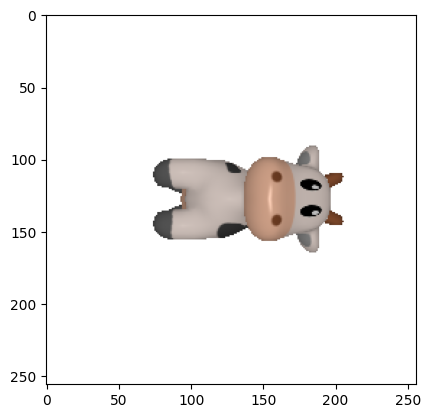

In [12]:
R_relative = [[0, 1, 0], 
              [-1, 0, 0], 
              [0, 0, 1]]
T_relative = [0, 0, 0]
rendered_image = render_textured_cow(R_relative=R_relative, T_relative=T_relative, device=device)
plt.imshow(rendered_image)
plt.savefig(f'{image_folder_name}/cow_roll.png')

---

![transform2](images/transform2.jpg)


To achieve this transform we have to rotate about y (yaw) and translate about x and z:

$R_{\text{relative}} = \begin{bmatrix} 0 & 0 & 1 \\ 0 & 1 & 0 \\ -1 & 0 & 0 \end{bmatrix}$


$T_{\text{relative}} = \begin{bmatrix} -2.5 \\ 0 \\ 3 \end{bmatrix}$



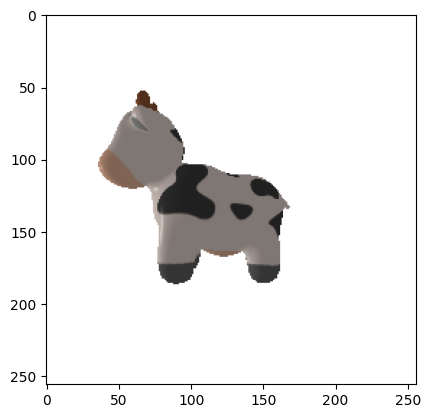

In [13]:
R_relative = [[0, 0, 1], 
              [0, 1, 0], 
              [-1, 0, 0]]
T_relative = [-2.5, 0, 3]
rendered_image = render_textured_cow(R_relative=R_relative, T_relative=T_relative, device=device)
plt.imshow(rendered_image)
plt.savefig(f'{image_folder_name}/cow_yaw_and_translate.png')

---

![transform3](images/transform3.jpg)


To achieve this, we simply translate along the z axis:

$R_{\text{relative}} = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}$


$T_{\text{relative}} = \begin{bmatrix} 0 \\ 0 \\ 5 \end{bmatrix}$



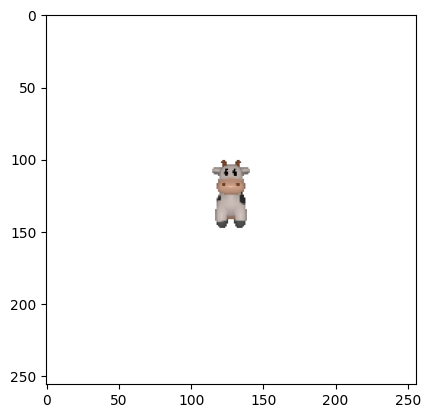

In [14]:
R_relative = [[1, 0, 0], 
              [0, 1, 0], 
              [0, 0, 1]]
T_relative = [0, 0, 5]
rendered_image = render_textured_cow(R_relative=R_relative, T_relative=T_relative, device=device)
plt.imshow(rendered_image)
plt.savefig(f'{image_folder_name}/cow_translate_back.png')

---

![transform4](images/transform4.jpg)


To achieve this, we simply translate along the x axis:

$R_{\text{relative}} = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}$


$T_{\text{relative}} = \begin{bmatrix} 0.8 \\ 0 \\ 0 \end{bmatrix}$



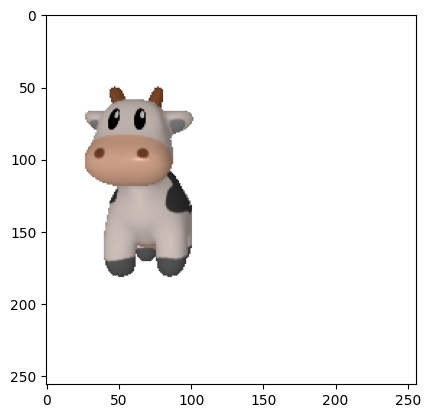

In [15]:
R_relative = [[1, 0, 0], 
              [0, 1, 0], 
              [0, 0, 1]]
T_relative = [.8, 0, 0]
rendered_image = render_textured_cow(R_relative=R_relative, T_relative=T_relative, device=device)
plt.imshow(rendered_image)
plt.savefig(f'{image_folder_name}/cow_translate_right.png')

# Q5

# Q5.1

In [16]:
def render_point360(point_cloud, image_size=256, dist=3, elev=3, device=None, duration=60, output_path=f'{image_folder_name}/plants.gif', bg_color=(1,1,1), flip_y=True):
    if device is None:
        device = get_device()

    images = []

    # Get the renderer.

    renderer = get_points_renderer(image_size=image_size, device=device, background_color=bg_color)

    # Place a point light in front of the cow.
    lights = pytorch3d.renderer.PointLights(location=[[0, 0, -3]], device=device)
    
    # Render the mesh from 360 different angles
    for degree in range(360):
        rot, t = look_at_view_transform(dist=dist, elev=elev, azim=degree, degrees=True, device=device)
        if flip_y:
            rot[:, 0:2, 1] *= -1  # change the sign of the y axis to match the camera coordinate system
        cameras = pytorch3d.renderer.FoVPerspectiveCameras(
            R=rot, T=t, fov=60, device=device
        )
        
        rend = renderer(point_cloud, cameras=cameras, lights=lights)
        rend = rend.cpu().numpy()[0, ..., :3]
        rend = (np.clip(rend, 0, 1) * 255).astype(np.uint8)
        images.append(rend)
    
    imageio.mimsave(output_path, images, duration=duration, loop=0)

    return Image(output_path)

In [17]:

# Load all the data
data = load_rgbd_data() 

# Load data for image 1 
image1 = torch.Tensor(data['rgb1'])
mask1 = torch.Tensor(data['mask1'])
depth1 = torch.Tensor(data['depth1'])
camera1 = data['cameras1']

# Load data for image 2 
image2 = torch.Tensor(data['rgb2'])
mask2 = torch.Tensor(data['mask2'])
depth2 = torch.Tensor(data['depth2'])
camera2 = data['cameras2']


In [18]:
# Process the first image

points1, rgba1 = unproject_depth_image(image1, mask1, depth1, camera1)

points1 = points1.unsqueeze(0).to(device)
rgba1 = rgba1.unsqueeze(0).to(device)

p_cloud1 = pytorch3d.structures.Pointclouds(points=points1, features=rgba1)
plant1_name = f'{image_folder_name}/plant1.gif'
render_point360(p_cloud1, dist=8, elev=-10, duration=20, output_path=plant1_name)
display_gifs_side_by_side([plant1_name])

/home/mikea/anaconda3/envs/learning3d/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [19]:
# Process the second image

points2, rgba2 = unproject_depth_image(image2, mask2, depth2, camera2)

points2 = points2.unsqueeze(0).to(device)
rgba2 = rgba2.unsqueeze(0).to(device)

plant2_name = f'{image_folder_name}/plant2.gif'
p_cloud2 = pytorch3d.structures.Pointclouds(points=points2, features=rgba2)
render_point360(p_cloud2, dist=8, elev=-10, duration=20, output_path=plant2_name)
display_gifs_side_by_side([plant2_name])

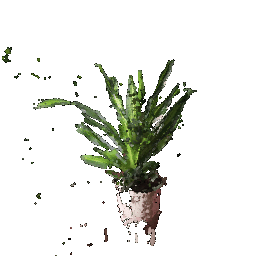

In [20]:
# Process both images
all_points = [points1[0], points2[0]]
all_rgba = [rgba1[0], rgba2[0]]

points = torch.cat(all_points, dim=0)
rgba = torch.cat(all_rgba, dim=0)

points = points.unsqueeze(0).to(device)
rgba = rgba.unsqueeze(0).to(device)

p_cloud = pytorch3d.structures.Pointclouds(points=points, features=rgba)
plant3_name = f'{image_folder_name}/plants_combine.gif'
render_point360(p_cloud, dist=8, elev=10, duration=20, output_path=plant3_name, bg_color=(1,1,1))

In [21]:
display_gifs_side_by_side([plant1_name, plant2_name, plant3_name])

# Q5.2 

In [22]:
def get_torus_from_parametric(R=1.0, r=0.3, res=100, device=None):
    """
    Make a torus point cloud parametrically.

    R: Major radius
    r: Minor radius
    res: Resolution along u and v
    """
    if device is None:
        device = get_device()

    # Create a grid of parametric angles
    theta = torch.linspace(0, 2 * torch.pi, res)
    phi = torch.linspace(0, 2 * torch.pi, res)
    theta, phi = torch.meshgrid(theta, phi, indexing="ij")

    #  Use the parametric equations to get the 3D coordinates
    X = (R + r * torch.cos(theta)) * torch.cos(phi) # Note: Capital R is major radius (distance from center of tube to center of torus)
    Y = (R + r * torch.cos(theta)) * torch.sin(phi) # Note: Small r is minor radius (radius of the tube)
    Z = r * torch.sin(theta)

    # X, Y, Z are all going to be shape (theta len, phi len) where each entry is a specific theta evaluated using different phi's 

    # Format the points and use min max normalization to create a color gradient
    points = torch.stack([X.flatten(), Y.flatten(), Z.flatten()], dim=-1) # this gives us each vertex as a row vector, shape (N, 3)
    color = (points - points.min()) / (points.max() - points.min()) # Create color gradient by min-max normalizing the points 

    # Create the point cloud
    point_cloud = pytorch3d.structures.Pointclouds(
        points=[points], features=[color],
    ).to(device)
    return point_cloud

In [23]:
RESOLUTION = 100
point_cloud = get_torus_from_parametric(res=RESOLUTION)
torus_path = f'{image_folder_name}/torus_parametric.gif'
render_point360(point_cloud, dist=3, elev=10, duration=20, output_path=torus_path, bg_color=(1,1,1))
display_gifs_side_by_side([torus_path])

In [24]:
def get_ellipsoid_from_parametric(res=200, scale=1, axes=(1.0, 0.5, 0.5), device=None):
    """
    Make ellipsoid point cloud parametrically.
    
    scale: overall size of the ellipsoid
    axes: tuple of 3 floats, the radii along the x, y, z axes
    res: how many points to sample along each axis
    """

    if device is None:
        device = get_device()

    # "Scale" by increasing the axes lengths
    a, b, c = [scale * axis for axis in axes]
    
    # Make Parametric Grid
    theta = torch.linspace(0, 2*torch.pi, res, device=device)   # angle around the vertical axis
    phi = torch.linspace(0, torch.pi, res, device=device)       # angle from top to bottom
    theta, phi = torch.meshgrid(theta, phi, indexing="ij")

    # Use the parametric equations of ellipsoid to get back the 3D points
    X = a * torch.sin(phi) * torch.cos(theta)
    Y = b * torch.sin(phi) * torch.sin(theta)
    Z = c * torch.cos(phi)

    # Format the points and use min max normalization to create a color gradient
    points = torch.stack([X.flatten(), Y.flatten(), Z.flatten()], dim=-1)
    color = (points - points.min()) / (points.max() - points.min())
    point_cloud = pytorch3d.structures.Pointclouds(
        points=[points], features=[color],
    ).to(device)
    
    return point_cloud


In [25]:
RESOLUTION = 300
point_cloud = get_ellipsoid_from_parametric(res=RESOLUTION, scale=1.0,)
elilipsoid_path = f'{image_folder_name}/ellipsoid_parametric.gif'
render_point360(point_cloud, dist=3, elev=10, duration=20, output_path=elilipsoid_path, bg_color=(1,1,1))
display_gifs_side_by_side([elilipsoid_path])

# Q5.3

In [26]:
import mcubes

def render_torus_mesh_implictly(R=1, r=0.3, voxel_size=64, device=None):
    """
    Render a torus mesh implicitly.

    R: Major radius
    r: Minor radius
    voxel_size: The size of the voxel grid to use for the marching cubes algorithm.
    """
    if device is None:
        device = get_device()
    
    extents = R + r + 0.1 # +0.1 to give some padding when sampling, make sure torus fits in grid
    min_value = -extents
    max_value = extents

    # Create a voxel grid
    X, Y, Z = torch.meshgrid([torch.linspace(min_value, max_value, voxel_size)] * 3)

    # Evaluate the implicit equation of a torus at each voxel
    voxels = (torch.sqrt(X**2 + Y**2) - R) ** 2 + Z**2 - r**2 # implicit equation of a torus

    # Use marching cubes to extract the mesh
    vertices, faces = mcubes.marching_cubes(mcubes.smooth(voxels), isovalue=0)
    vertices = torch.tensor(vertices).float()
    faces = torch.tensor(faces.astype(int))

    # Vertex coordinates are indexed by array position, so we need to
    # renormalize the coordinate system.
    vertices = (vertices / voxel_size) * (max_value - min_value) + min_value # convert from voxel coordinates (grid space) to cartesian coordinates (world space)
    textures = (vertices - vertices.min()) / (vertices.max() - vertices.min())
    textures = pytorch3d.renderer.TexturesVertex(vertices.unsqueeze(0))

    mesh = pytorch3d.structures.Meshes([vertices], [faces], textures=textures).to(
        device
    )

    return mesh 

In [27]:
point_cloud = render_torus_mesh_implictly(R=1, r=0.3, voxel_size=64, device=device)
torus_impl_path = f'{image_folder_name}/torus_implcit.gif'
render_mesh360(point_cloud, dist=3, elev=0, duration=20, output_path=torus_impl_path)
display_gifs_side_by_side([torus_impl_path])

Question: Point clouds are faster to render and use less memory since they store only points without connectivity. However, they can appear sparse and lack surface continuity. Meshes provide higher visual quality with continuous surfaces and better shading, but require more memory and are slower to render.


Response: Point clouds are faster to render and use less memory since they store only points without connectivity. However, they can appear sparse and lack surface continuity. Meshes provide higher visual quality with continuous surfaces, but require more memory and are slower to render.

In [28]:
def render_ellipsoid_mesh_implicitly(axes=(1.0, 0.5, 0.5), voxel_size=64, device=None):
    """
    Render an ellipsoid mesh implicitly.

    axes: array representing length along each x, y, z axes of the ellipsoid
    voxel_size:  The size of the voxel grid to use for the marching cubes algorithm.
        
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Similar  to torus, make grid large enough to fit ellipsoid
    a, b, c = axes
    extents = max(a, b, c) + 0.1  # padding
    min_value = -extents
    max_value = extents

    X, Y, Z = torch.meshgrid([torch.linspace(min_value, max_value, voxel_size)]*3, indexing='ij')

    # Implicit ellipsoid equation
    voxels = (X ** 2)/(a ** 2) + (Y ** 2)/(b ** 2) + (Z ** 2)/(c ** 2) - 1

    # Marching cubes to extract the mesh
    vertices, faces = mcubes.marching_cubes(mcubes.smooth(voxels.numpy()), isovalue=0)
    vertices = torch.tensor(vertices).float()
    faces = torch.tensor(faces.astype(int))

    # Map voxel coordinates back to world coordinates
    vertices = (vertices / voxel_size) * (max_value - min_value) + min_value

    # Simple texture based on position
    textures = (vertices - vertices.min()) / (vertices.max() - vertices.min())
    textures = pytorch3d.renderer.TexturesVertex(vertices.unsqueeze(0))

    mesh = pytorch3d.structures.Meshes([vertices], [faces], textures=textures).to(device)
    return mesh


In [29]:
ellipsoid_mesh = render_ellipsoid_mesh_implicitly(voxel_size=64, device=device)
elilipsoid_impli_path = f'{image_folder_name}/ellipsoid_implicit.gif'
render_mesh360(ellipsoid_mesh, dist=3, elev=10, duration=20, output_path=elilipsoid_impli_path)
display_gifs_side_by_side([elilipsoid_impli_path])

# Q6

In [30]:
def get_star_from_parametric(res=200, scale=1.0, spikes=2, device=None):
    """
    Generate a 3D star point cloud parametrically.

    res: Resolution along both parametric directions
    scale: Overall scaling of the shape
    spikes: Number of spikes of the star
    
    """
    if device is None:
        device = get_device()

    #  Create a grid of parametric angles
    theta = torch.linspace(0, 2*torch.pi, res)   
    phi = torch.linspace(0, torch.pi, res)   
    theta, phi = torch.meshgrid(theta, phi, indexing="ij")

    # Parametric equation for 3D star
    r = scale * (1 + 0.5 * torch.sin(spikes * theta) * torch.sin(spikes * phi))

    # --- Spherical to Cartesian ---
    X = r * torch.sin(phi) * torch.cos(theta)
    Y = r * torch.sin(phi) * torch.sin(theta)
    Z = r * torch.cos(phi)

    # Flatten points
    points = torch.stack([X.flatten(), Y.flatten(), Z.flatten()], dim=-1)

    # Color gradient by position
    color = (points - points.min()) / (points.max() - points.min())

    # Create point cloud
    point_cloud = pytorch3d.structures.Pointclouds(
        points=[points], features=[color],
    ).to(device)

    return point_cloud


In [31]:
RESOLUTION = 150
point_cloud = get_star_from_parametric(res=RESOLUTION, spikes=5)
star_path = f'{image_folder_name}/star_parametric.gif'
render_point360(point_cloud, dist=3, elev=10, duration=20, output_path=star_path, bg_color=(0, 0, 0))
display_gifs_side_by_side([star_path])

# Q7

In [32]:
from starter.utils import load_cow_mesh

def sample_points_on_mesh(vertices, faces, num_samples, device):

    # Get the vertices of each face
    v0 = vertices[faces[:, 0], :] # get the first vertex of each face
    v1 = vertices[faces[:, 1], :] # get the second vertex of each face
    v2 = vertices[faces[:, 2], :] # get the third vertex of each face
    
    # compute the area of each triangle
    edge1 = v1 - v0
    edge2 = v2 - v0
    area = 1/2 * torch.norm(torch.cross(edge1, edge2, dim=1), dim=1)  # Note the magnitude of the cross product of two vectors tells you the area that two vectors span "up till their respective edges" which would be base * height (Square). Divide by 2 to get triangular area 
    
    # Normalize the areas to create a probability distribution
    area_probs = area / area.sum()
    
    # Sample face indices according to area probabilities
    sampled_face_indices = torch.multinomial(area_probs, num_samples)

    # Get the sampled faces vertices
    sampled_v0 = v0[sampled_face_indices]
    sampled_v1 = v1[sampled_face_indices]
    sampled_v2 = v2[sampled_face_indices]
    

    # Now we need to sample points within each triangle --> Use randomly uniform barycentric coordinates
    u = torch.rand(num_samples, 1, device=device)
    v = torch.rand(num_samples, 1, device=device)
    # if any combo of u and v is over, subtract 1 to get it back within the correct range
    mask = u + v > 1
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]
    w = 1 - (u + v) # the remaining weight goes to w
    
    # Compute the sampled points from the verticies forming the faces using barycentric coordinates
    samples = u * sampled_v0 + v * sampled_v1 + w * sampled_v2
    
    return samples


def get_sampled_cow( cow_path="data/cow.obj", color=[0.7, 0.7, 1], res=100, device=None):
    if device is None:
        device = get_device()

    vertices, faces = load_cow_mesh(cow_path)
    vertices = vertices.unsqueeze(0).to(device)  # (1, N_v, 3)
    faces = faces.unsqueeze(0).to(device)  # (1, N_f, 3)
    textures = torch.ones_like(vertices, device=device)
    textures = textures * torch.tensor(color, device=device).view(1, 1, 3)

    mesh = pytorch3d.structures.Meshes(
            verts=vertices,
            faces=faces,
            textures=pytorch3d.renderer.TexturesVertex(textures),
        )
    verts = sample_points_on_mesh(vertices[0], faces[0], num_samples=res, device=device)  # (N_v, 3)
    verts = verts.unsqueeze(0)  # (1, N_v, 3)

    textures = torch.ones_like(verts, device=device)
    textures = textures * torch.tensor(color, device=device).view(1, 1, 3)

    point_cloud = pytorch3d.structures.Pointclouds(points=verts, features=textures)

    

    return point_cloud, mesh


In [33]:
original_name = f'{image_folder_name}/original_cow_mesh.gif'
point_name = f'{image_folder_name}/sampled_cow_points_10.gif'
sampled_point_cloud, cow_mesh = get_sampled_cow(res=10)
mesh_img = render_mesh360(cow_mesh, dist=3, elev=3, output_path=original_name, duration=20)
point_img = render_point360(sampled_point_cloud, dist=3, elev=3, output_path=point_name, duration=20, flip_y=False)

display_gifs_side_by_side([original_name, point_name])

In [34]:
original_name = f'{image_folder_name}/original_cow_mesh.gif'
point_name = f'{image_folder_name}/sampled_cow_points_100.gif'
sampled_point_cloud, cow_mesh = get_sampled_cow(res=100)
mesh_img = render_mesh360(cow_mesh, dist=3, elev=3, output_path=original_name, duration=20)
point_img = render_point360(sampled_point_cloud, dist=3, elev=3, output_path=point_name, duration=20, flip_y=False)

display_gifs_side_by_side([original_name, point_name])

In [35]:
original_name = f'{image_folder_name}/original_cow_mesh.gif'
point_name = f'{image_folder_name}/sampled_cow_points_1000.gif'
sampled_point_cloud, cow_mesh = get_sampled_cow(res=1000)
mesh_img = render_mesh360(cow_mesh, dist=3, elev=3, output_path=original_name, duration=20)
point_img = render_point360(sampled_point_cloud, dist=3, elev=3, output_path=point_name, duration=20, flip_y=False)

display_gifs_side_by_side([original_name, point_name])